<a href="https://colab.research.google.com/github/inf032/introducaoML/blob/master/Farmaco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip (22.0 MB)


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

from pandas_profiling import ProfileReport

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics  import mean_squared_error
from sklearn.dummy import DummyRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.impute._base import _BaseImputer



In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import KNNImputer
from sklearn.impute._base import _BaseImputer

class ImputerWithMissingMark (BaseEstimator, TransformerMixin):

    def addColunas_IMPUTED(self, X) :
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          copia[f'{col}{self.postfix}'] = copia[col].isna().astype(int)
      return copia

    def col_with_nan(self, X) :
      list_col_with_nan = []
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          list_col_with_nan.append(f'{col}{self.postfix}')
      return list_col_with_nan

    def __init__(self, imputer=KNNImputer(), postfix = '_IMPUTED'):
      self.imputer = imputer
      self.col_name = None
      self.fitted = False
      self.col_with_nan_name = None
      self.postfix = postfix

    def fit(self, X, y=None):
      if(self.fitted == False) :
        self.fitted = True
        self.col_name = X.columns.values
        self.imputer.fit(X)
        self.col_with_nan_name = self.col_with_nan(X)
      return self

    def transform(self, X, y=None):
      if(self.fitted == True) :
        copia = self.addColunas_IMPUTED(X)
        transformed = pd.DataFrame(self.imputer.transform(copia[self.col_name]))
        transformed.columns = X.columns
        transformed.index = X.index
        for col in self.col_with_nan_name :
          transformed[col] = copia[col]
        return transformed
      else :
        return X

    def get_params(self, deep=True):
      # retorna um dicionário com os atributos e seus respectivos valores
      return {"imputer": self.imputer, 
              "postfix": self.postfix}
      
    def set_params(self, **parameters):
      # iterando pelos elementos passados e definindo-os na classe
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self   

Leitura dos Dados


In [28]:
SEED = 1234
np.random.seed(SEED)
warnings.filterwarnings(action='once')

dataFrame = pd.read_csv('https://raw.githubusercontent.com/inf032/introducaoML/master/data/farmaco.csv')
df = dataFrame.copy()


In [29]:
print(df.columns)
df.columns = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 
                  'NA_K', 'FARMACO']
df.sample(5)

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')


,IDADE,SEXO,PA,COLESTEROL,NA_K,FARMACO
58,60.0,M,NORMAL,NORMAL,10.091,MEDB
6,49.0,F,NORMAL,HIGH,16.275,MEDA
31,74.0,M,HIGH,HIGH,9.567,MEDA
7,41.0,M,LOW,HIGH,11.037,MEDB
29,45.0,M,LOW,HIGH,17.951,MEDA


In [30]:
df.describe()

,IDADE,NA_K
count,223.000000,220.000000
mean,45.502242,16.186264
std,25.939443,7.731283
min,13.000000,3.870000
25%,30.500000,10.291750
50%,45.000000,13.952500
75%,58.000000,19.822000
max,333.000000,41.270000


In [31]:
ausentes = (1 - df.isna()).mean()
dfAusentes = pd.DataFrame(ausentes, columns=['pct'])
dfAusentes['feature'] = df.columns
dfAusentes.index = range(dfAusentes.shape[0])
dfAusentes

,pct,feature
0,0.991111,IDADE
1,1.000000,SEXO
2,0.960000,PA
3,0.973333,COLESTEROL
4,0.977778,NA_K
5,1.000000,FARMACO


In [32]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

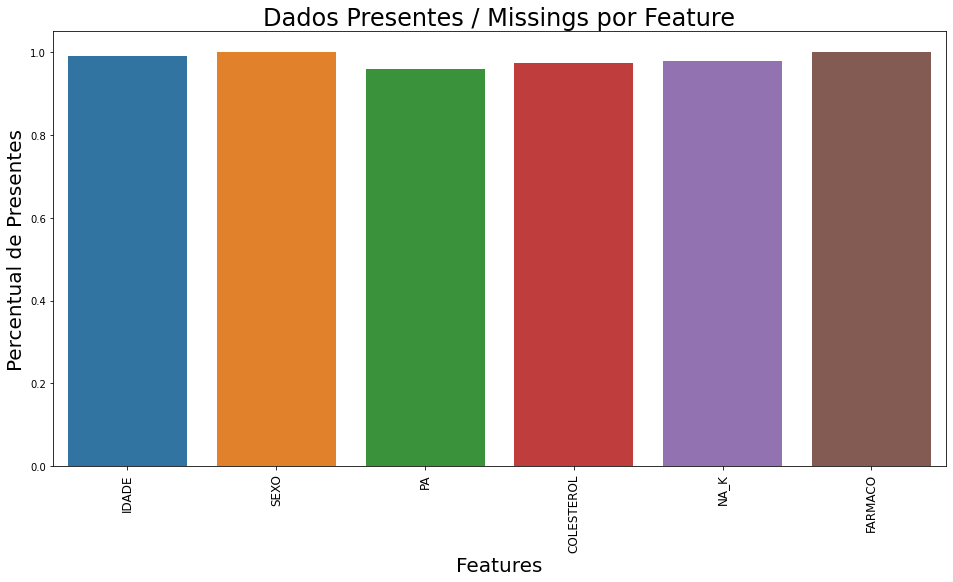

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
sns.barplot(data=dfAusentes, x='feature', y='pct', ax=ax)
ax.set_title('Dados Presentes / Missings por Feature', fontsize = 24)
ax.set_ylabel('Percentual de Presentes', fontsize = 20)
ax.set_xlabel('Features', fontsize = 20)
ax.set_xticklabels(labels = dfAusentes.feature, rotation=90, fontsize = 12)
fig.show()

In [34]:
preditoras = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K']
alvo = 'FARMACO'

X = df[preditoras]
y = df[alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)

print(f'Treinaremos com {X_train.shape[0]} individuos e testaremos com {X_test.shape[0]} individuos')

Treinaremos com 157 individuos e testaremos com 68 individuos


Codificar o MEDA-MEDB como inteiro

In [35]:
le = LabelEncoder()
y_train = pd.Series(le.fit_transform(y_train.values))
y_train



0      0
1      1
2      1
3      0
4      1
      ..
152    1
153    0
154    1
155    1
156    0
Length: 157, dtype: int64

In [36]:
X_train.head(10)

,IDADE,SEXO,PA,COLESTEROL,NA_K
48,23.0,M,NORMAL,HIGH,31.686
140,49.0,M,HIGH,NORMAL,6.269
174,42.0,M,HIGH,NORMAL,12.766
26,31.0,M,HIGH,HIGH,30.366
191,23.0,M,HIGH,HIGH,8.011
88,37.0,F,HIGH,NORMAL,23.091
45,66.0,F,NORMAL,NORMAL,8.107
49,28.0,F,LOW,HIGH,19.796
126,66.0,M,HIGH,HIGH,16.347
210,50.0,M,LOW,NaN,5.900


In [37]:
oe = OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], ['LOW', 'NORMAL', 'HIGH']], handle_unknown='use_encoded_value', unknown_value=np.nan)
X_train_oe = X_train.copy()
X_train_oe[['PA', 'COLESTEROL']] = oe.fit_transform(X_train_oe[['PA', 'COLESTEROL']])
X_train_oe.head(10)

,IDADE,SEXO,PA,COLESTEROL,NA_K
48,23.0,M,1.0,2.0,31.686
140,49.0,M,2.0,1.0,6.269
174,42.0,M,2.0,1.0,12.766
26,31.0,M,2.0,2.0,30.366
191,23.0,M,2.0,2.0,8.011
88,37.0,F,2.0,1.0,23.091
45,66.0,F,1.0,1.0,8.107
49,28.0,F,0.0,2.0,19.796
126,66.0,M,2.0,2.0,16.347
210,50.0,M,0.0,NaN,5.900


In [38]:
ohe = OneHotEncoder(drop='if_binary', sparse=False)
X_train_ohe = X_train_oe.copy()
X_train_ohe[['MASC_FEM']] = ohe.fit_transform(X_train_ohe[['SEXO']])
X_train_ohe.drop(['SEXO'], axis='columns', inplace=True)
X_train_ohe.head(10)

,IDADE,PA,COLESTEROL,NA_K,MASC_FEM
48,23.0,1.0,2.0,31.686,1.0
140,49.0,2.0,1.0,6.269,1.0
174,42.0,2.0,1.0,12.766,1.0
26,31.0,2.0,2.0,30.366,1.0
191,23.0,2.0,2.0,8.011,1.0
88,37.0,2.0,1.0,23.091,0.0
45,66.0,1.0,1.0,8.107,0.0
49,28.0,0.0,2.0,19.796,0.0
126,66.0,2.0,2.0,16.347,1.0
210,50.0,0.0,NaN,5.900,1.0


In [39]:
ss = StandardScaler()
X_train_ss = X_train_ohe.copy()
X_train_ss = pd.DataFrame(ss.fit_transform(X_train_ss))
X_train_ss.columns = X_train_ohe.columns
X_train_ss.index = X_train_ohe.index


In [40]:
X_train_iwmm = X_train_ss.copy()
imputermissing = ImputerWithMissingMark(postfix='_MISSING')
X_train_iwmm = imputermissing.fit_transform(X_train_iwmm)
X_train_iwmm.head(10)


,IDADE,PA,COLESTEROL,NA_K,MASC_FEM,IDADE_MISSING,PA_MISSING,COLESTEROL_MISSING,NA_K_MISSING
48,-0.784825,-0.173244,0.989675,2.025587,0.932227,0,0,0,0
140,0.125716,1.015843,-0.836511,-1.313975,0.932227,0,0,0,0
174,-0.119430,1.015843,-0.836511,-0.460328,0.932227,0,0,0,0
26,-0.504659,1.015843,0.989675,1.852151,0.932227,0,0,0,0
191,-0.784825,1.015843,0.989675,-1.085092,0.932227,0,0,0,0
88,-0.294534,1.015843,-0.836511,0.896282,-1.072700,0,0,0,0
45,0.721069,-0.173244,-0.836511,-1.072478,-1.072700,0,0,0,0
49,-0.609721,-1.362331,0.989675,0.463349,-1.072700,0,0,0,0
126,0.721069,1.015843,0.989675,0.010182,0.932227,0,0,0,0
210,0.160736,-1.362331,-0.106037,-1.362458,0.932227,0,0,1,0


In [41]:
X_test_transformed = X_test.copy()
X_test_transformed[['PA', 'COLESTEROL']] = oe.transform(X_test[['PA', 'COLESTEROL']])
X_test_transformed[['MASC_FEM']] = ohe.transform(X_test_transformed[['SEXO']])
X_test_transformed.drop(['SEXO'], axis='columns', inplace=True)
X_train_ss = pd.DataFrame(ss.transform(X_test_transformed))
X_train_ss.columns = X_test_transformed.columns
X_train_ss.index = X_test_transformed.index
X_test_transformed = imputermissing.transform(X_train_ss)
X_test_transformed.head()
y_test = pd.Series(le.transform(y_test.values))


In [42]:
def report_score(model, X_train, X_test, y_train, y_test) :
 score = model.fit(X_train, y_train).score(X_test, y_test)
 print(f'Modelo [{model.__class__.__name__}]: {np.round(score*100, 2)}%')


In [76]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

report_score(DecisionTreeClassifier(), X_train_iwmm, X_test_transformed, y_train, y_test)
report_score(SVC(), X_train_iwmm, X_test_transformed, y_train, y_test)
report_score(MLPClassifier(), X_train_iwmm, X_test_transformed, y_train, y_test)
report_score(GradientBoostingClassifier(), X_train_iwmm, X_test_transformed, y_train, y_test)
report_score(RandomForestClassifier(), X_train_iwmm, X_test_transformed, y_train, y_test)

Modelo [DecisionTreeClassifier]: 91.18%
Modelo [SVC]: 92.65%


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Modelo [MLPClassifier]: 92.65%
Modelo [GradientBoostingClassifier]: 95.59%
Modelo [RandomForestClassifier]: 92.65%


In [91]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], 
                                                                                     ['LOW', 'NORMAL', 'HIGH']], 
                                                                          handle_unknown='use_encoded_value',
                                                                          unknown_value=np.nan))
                                     ])
onehot_transformer = Pipeline(steps=[('one_hot_encoder',  OneHotEncoder(drop='if_binary', sparse=False))])


col_transformer = ColumnTransformer(transformers=[('pa_colesterol', ordinal_transformer, ['PA', 'COLESTEROL']),
                                                  ('sex', onehot_transformer, ['SEXO'])],
                                    remainder='passthrough')

model = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                        ('imputer', KNNImputer()), ('classificador', SVC())])

model.fit(X_train, y_train)

model.score(X_test, y_test)



0.9411764705882353